In [1]:
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
# size of the encoding representation
encoding_dim = 32

# Prepare the data

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


# Build the simplest AE

In [5]:
# This is our input image
input_img = tf.keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)


# Separate encoder model

In [6]:
encoder = tf.keras.Model(input_img, encoded)

# Separate decoder model

In [7]:
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))


# Compile the AE

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the AE

In [9]:
start_train_time = time.time()
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

end_train_time = time.time()
hours_train, rem = divmod(end_train_time-start_train_time, 3600)
minutes_train, seconds_train = divmod(rem, 60)
print("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours_train),int(minutes_train),seconds_train))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 63us/sample - loss: 0.2745 - val_loss: 0.1876
Epoch 2/50
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1707 - val_loss: 0.1542
Epoch 3/50
60000/60000 [==============================] - 3s 51us/sample - loss: 0.1449 - val_loss: 0.1348
Epoch 4/50
60000/60000 [==============================] - 3s 51us/sample - loss: 0.1295 - val_loss: 0.1224
Epoch 5/50
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1190 - val_loss: 0.1137
Epoch 6/50
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1116 - val_loss: 0.1073
Epoch 7/50
60000/60000 [==============================] - 3s 53us/sample - loss: 0.1062 - val_loss: 0.1029
Epoch 8/50
60000/60000 [==============================] - 3s 51us/sample - loss: 0.1022 - val_loss: 0.0994
Epoch 9/50
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0994 - val_

# Encode and decode some digits

In [10]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Plot the original and reconstructed data

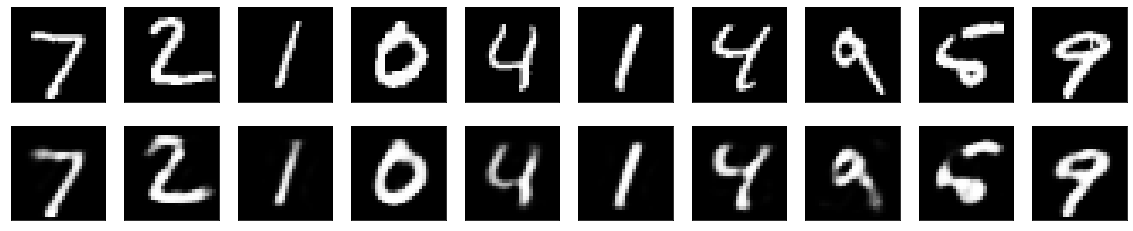

In [11]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional autoencoder

### Ecoder 

In [11]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [12]:
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

### Autoencoder

In [13]:
autoencoder = tf.keras.Model(input_img, decoded)

In [14]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

# Compile the model

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Load again the daata

In [16]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize but not unpack, just add channel dimens

In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print("x_train.shape = ",x_train.shape)
print("x_test.shape = ",x_test.shape)

x_train.shape =  (60000, 28, 28, 1)
x_test.shape =  (10000, 28, 28, 1)


# Train the autoencoder

In [18]:
start_time = time.time()
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
end_train_time = time.time()
hours_train, rem = divmod(end_train_time-start_train_time, 3600)
minutes_train, seconds_train = divmod(rem, 60)
print("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours_train),int(minutes_train),seconds_train))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


W1103 23:34:05.977822 140476442851136 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (2.626896). Check your callbacks.


  128/60000 [..............................] - ETA: 23:35 - loss: 0.7054

W1103 23:34:06.081088 140476442851136 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (1.314671). Check your callbacks.


60000/60000 [==============================] - 39s 651us/sample - loss: 0.2132 - val_loss: 0.1417
Epoch 2/50
60000/60000 [==============================] - 37s 609us/sample - loss: 0.1310 - val_loss: 0.1224
Epoch 3/50
60000/60000 [==============================] - 37s 610us/sample - loss: 0.1199 - val_loss: 0.1155
Epoch 4/50
60000/60000 [==============================] - 37s 611us/sample - loss: 0.1144 - val_loss: 0.1113
Epoch 5/50
60000/60000 [==============================] - 37s 611us/sample - loss: 0.1108 - val_loss: 0.1082
Epoch 6/50
60000/60000 [==============================] - 37s 614us/sample - loss: 0.1081 - val_loss: 0.1064
Epoch 7/50
60000/60000 [==============================] - 36s 601us/sample - loss: 0.1061 - val_loss: 0.1041
Epoch 8/50
60000/60000 [==============================] - 35s 584us/sample - loss: 0.1045 - val_loss: 0.1028
Epoch 9/50
60000/60000 [==============================] - 35s 583us/sample - loss: 0.1032 - val_loss: 0.1017
Epoch 10/50
60000/60000 [=====

# Predict on test data

In [19]:
decoded_imgs = autoencoder.predict(x_test)

# Plot them

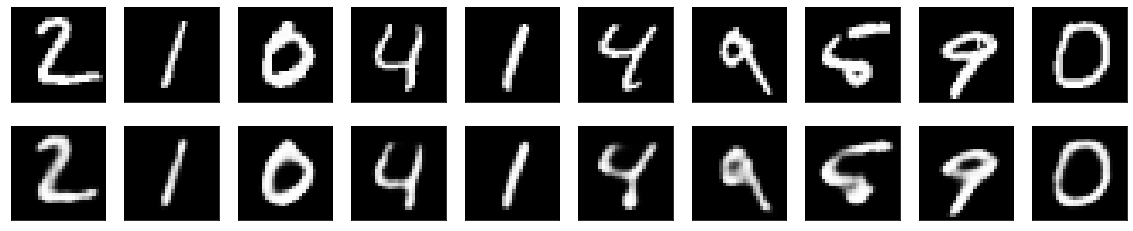

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Application to image denoising

# Load the data and add noise

In [21]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Plot some noisy digits

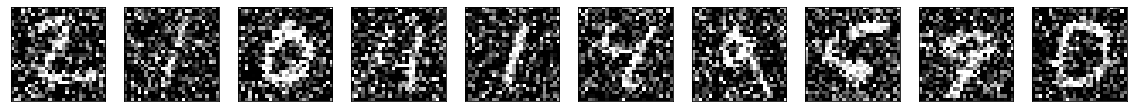

In [22]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Create the autoencoder

In [23]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Train it

In [24]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.1677 - val_loss: 0.1172
Epoch 2/10
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.1139 - val_loss: 0.1100
Epoch 3/10
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.1081 - val_loss: 0.1050
Epoch 4/10
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.1051 - val_loss: 0.1031
Epoch 5/10
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.1030 - val_loss: 0.1011
Epoch 6/10
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.1015 - val_loss: 0.0999
Epoch 7/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.1004 - val_loss: 0.0992
Epoch 8/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0997 - val_loss: 0.0983
Epoch 9/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0989 - val_

# Encode and decode test data

In [25]:
decoded_imgs = autoencoder.predict(x_test)

# Plot the original and reconstructed data

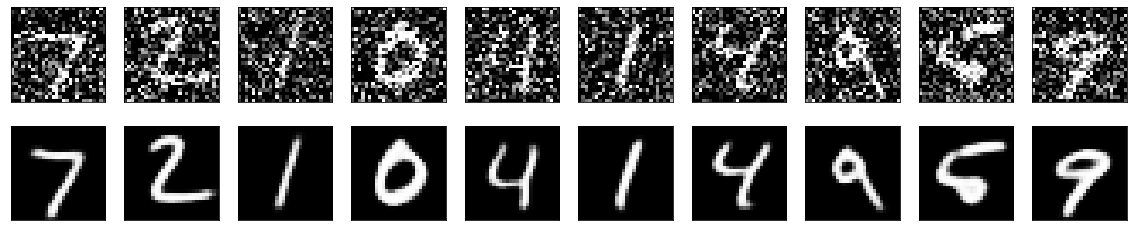

In [26]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()